# Identifying Pneumonia In Pediatric Chest X-Rays With Neural Networks

### Authors: Eric Denbin & Jesse Markowitz

![healthy vs penumonia cxr](images/healthy_vs_pneumonia_cxr.png)

In [2]:
# Load dependencies
import os, shutil
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

from project_functions import get_images, preprocess_dense_data, preprocess_cnn_data, visualize_results_cnn,\
                                 visualize_training_results, get_class_weights, cnn_model

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Business Understanding

Pneumonia is the presence of liquid in the lungs as a result of bacterial or viral infection. It is the leading cause of death in children under 5, accounting for 19% of all deaths worldwide in that age range. 

Pneumonia can also be difficult to diagnose as there is no "gold standard" indication for it. Medical professionals use a combination of symptoms and scans, such as chest x-rays (CXR) to make a positive diagnosis.

<img src="images/infographic-pediatricpneumonia.jpg" alt="pneumonia infographic from WHO" width="400"/>

Scans can be ambiguous and difficult to interpret, presenting another source of error. According to a study in the Journal of the American Academy of Pediatrics, 8.9% of children with a negative CXR were nonetheless diagnosed with pneumonia ([source](https://pediatrics.aappublications.org/content/142/3/e20180236)). This means that the doctors in the study correctly diagnosed patients with pneumonia 91.1% of the time. This postive identification rate is known in the medical community as "sensitivity" and in the data science community as "recall." We are using recall as our primary metric for success because we want to avoid labeling unhealthy patients as healthy.

This presents a good use case for machine learning image classification models. By training a model to identify CXRs that present positive for pneumonia, we can provide a consistent and powerful tool for medical professionals to use as part of their diagnostic toolkit.

## Data Understanding

Our dataset consists of 5,863 pediatric chest radiographs (X-ray images) from the Guangzhou Women and Children's Medical Center, via [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). All patients were 1-5 years old and the chest x-rays were taken in the course of routine care.

The original `val` folder from Kaggle contained only 16 images total, 8 from each class, which is not a sufficient size for validation. We chose to move all `val` images into the `train` folder. We will then use the `val_split` parameter in `flow_from_directory` to instantiate a validation set.

The following file structure provides the ground truth labeling needed to train the models. If you wish to run our code, you will need to reorganize the Kaggle dataset in the same way:
```
└── chest_xray
    ├── train
    │    ├──NORMAL
    │    └──PNEUMONIA
    └── test
         ├──NORMAL
         └──PNEUMONIA
```

### Load the data

To load the dataset using Keras's `ImageDataGenerator` class with the `flow_from_directory` method, as well as to inspect the images manually, we first need to specify the filepaths used to access the image folders, being sure to specify `train` and `test`, as well as `NORMAL` vs `PNEUMONIA`.

In [3]:
# Filepaths
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test/' 

# Check functionality and num images
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
train_normal_dir

'chest_xray/train/NORMAL'

In [4]:
# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

In [5]:
# Check number of files; should be 1349 normal and 3883 pneumonia images in the training set
print('There are', len(os.listdir(train_normal_dir)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia_dir)), 'pneumonia images in the training set')

There are 1349 normal images in the training set
There are 3883 pneumonia images in the training set


In [6]:
# Get list of filenames of all training images
train_norm_filenames = os.listdir(train_normal_dir)
train_pneum_filenames = os.listdir(train_pneumonia_dir)

# Make list of full filepaths to each image
train_normal_filepaths = [os.path.join(train_normal_dir, name) for name in train_norm_filenames]
train_pneumonia_filepaths = [os.path.join(train_pneumonia_dir, name) for name in train_pneum_filenames]
train_normal_filepaths[:5]

['chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0427-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg']

In [11]:
# Get training images of normal and pneumonia
# Read each file in as an image
train_normal_images = get_images(train_normal_dir)
train_pneumonia_images = get_images(train_pneumonia_dir)

<ipython-input-17-9411ddf175ee>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(p*100))+'%' for p in ax.get_yticks()])


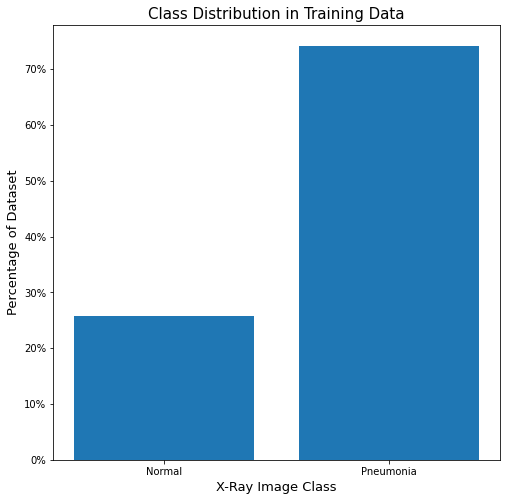

In [17]:
# Visualize class distribution in training data
total_images = len(train_normal_images) + len(train_pneumonia_images)
fig, ax = plt.subplots(figsize=(8, 8))

ax.bar(x=['Normal', 'Pneumonia'], height=[len(train_normal_images)/total_images, 
                                                  len(train_pneumonia_images)/total_images])
ax.set_title('Class Distribution in Training Data', size=15)
ax.set_ylabel('Percentage of Dataset', size=13)
ax.set_xlabel('X-Ray Image Class', size=13)
ax.set_yticklabels([str(int(p*100))+'%' for p in ax.get_yticks()])
plt.show()

There is a clear over-representation of target class images in the data, which presents an issue for modeling, even though we do want to emphasize correct prediction of the target class over general accuracy. We will experiment with adding in parameters to account for this, such as `class_weight`, as the current distribution is about 3:1 in favor of the target class (23% Normal, 77% Pneumonia).

## Data Preparation

### EDA: Image Samples and Metadata

#### Show the first 5 images from each set:

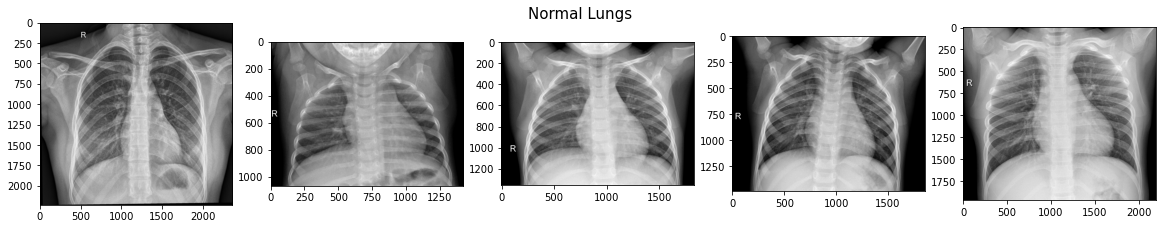

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_normal_images[i], cmap='gray')
fig.suptitle('Normal Lungs', fontsize=15, y=.8)
fig.tight_layout;

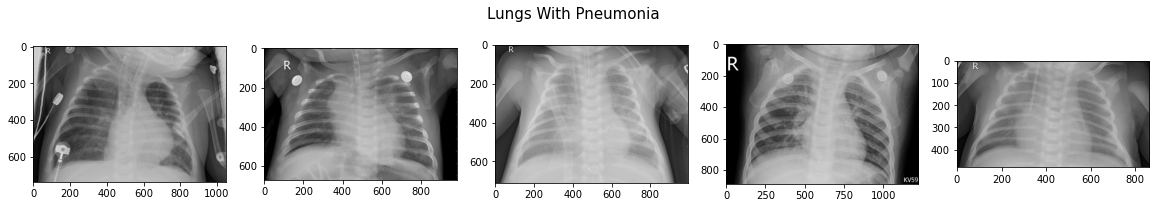

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_pneumonia_images[i], cmap='gray')
fig.suptitle('Lungs With Pneumonia', fontsize=15, y=.8)
fig.tight_layout;

All images are single-channel (black and white, not RGB) and almost all have an 'R' to designate the right-hand side lung. Typically, pneumonia lungs look "cloudy" or "fuzzy" compared to Normal.

From Kaggle:
> The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Essentially, this means that bacterial pneumonia typically gathers in one area of the lungs, while viral penumonia is more spread out.

#### Metadata

In [14]:
# Dimensions of images
normal_img_shapes = [img.shape for img in train_normal_images]
pneumonia_img_shapes = [img.shape for img in train_pneumonia_images]

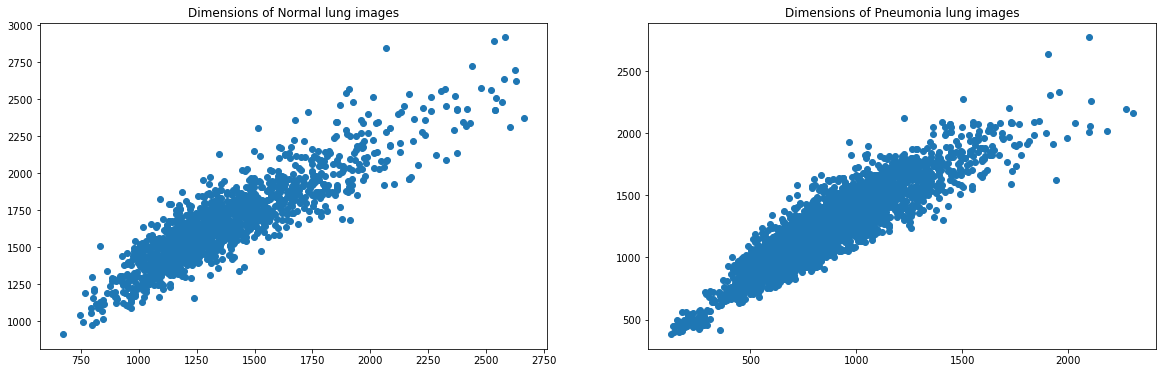

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Sizes of Normal lung images
ax1.scatter(x=[x[0] for x in normal_img_shapes], y=[x[1] for x in normal_img_shapes])
ax1.set_title('Dimensions of Normal lung images')

# Sizes of Pneumonia lung images
ax2.scatter(x=[x[0] for x in pneumonia_img_shapes], y=[x[1] for x in pneumonia_img_shapes])
ax2.set_title('Dimensions of Pneumonia lung images');

In [16]:
print('Smallest normal image dimension is ', np.min(normal_img_shapes))
print('Largest normal image dimension is ', np.max(normal_img_shapes))
print('Smallest pneumonia image dimension is ', np.min(pneumonia_img_shapes))
print('Largest pneumonia image dimension is ', np.max(pneumonia_img_shapes))

Smallest normal image dimension is  672
Largest normal image dimension is  2916
Smallest pneumonia image dimension is  (127, 384, 3)
Largest pneumonia image dimension is  (2304, 2160)


The linear relationships suggest similar aspect ratios, especially with smaller images (more variety with larger size images). However, there is a large variety in terms of image size. The largest images are over 3x the size of the smallest images! We will resize images during modeling using the `'target_size'` parameter in the `flow_from_directory` method with Keras image generators.

## Modeling with neural networks

We'll use the `ImageDataGenerator` class from Keras, as well as `flow_from_directory` to access the images and create our training and validation sets.

### First simple model

Our FSM consists of a basic fully connected dense neural network with only 1 hidden layer, plus an output layer. We'll reduce the image size to 100x100 pixels and feed in only 50 images. This model serves mainly as a proof of concept and provides baseline accuracy and recall scores.

In [18]:
# Load in data with a validation split of 20%
X_train, X_val, train_labels, val_labels = preprocess_dense_data(train_dir,
                                                                 target_size=(100, 100), 
                                                                 batch_size=50)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [19]:
# Instatiate model
fsm = models.Sequential()

# Add model layers
fsm.add(Dense(32, activation='relu', input_shape=(10000,)))
fsm.add(Dense(1, activation='sigmoid'))

# Compile
fsm.compile(optimizer='sgd',
            loss='binary_crossentropy',
            metrics=['acc', 'Recall'])

In [20]:
# Train the model
history = fsm.fit(X_train, train_labels, 
                  epochs=50,
                  batch_size=10,
                  validation_data=(X_val, val_labels))

Epoch 1/50
5/5 [==============================] - 0s 66ms/step - loss: 0.7861 - acc: 0.7200 - recall: 0.8421 - val_loss: 0.5301 - val_acc: 0.7800 - val_recall: 1.0000
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 0.5648 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.5302 - val_acc: 0.7800 - val_recall: 1.0000
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6096 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.4879 - val_acc: 0.7800 - val_recall: 1.0000
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 0.5772 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.5018 - val_acc: 0.7800 - val_recall: 1.0000
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5401 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.5302 - val_acc: 0.7800 - val_recall: 1.0000
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5053 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.4716 - val_acc: 0.7800 - val_recall: 1.0000
Epo

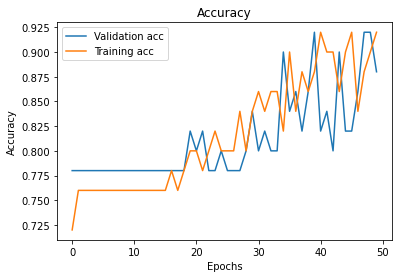

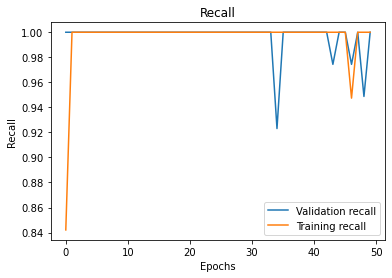

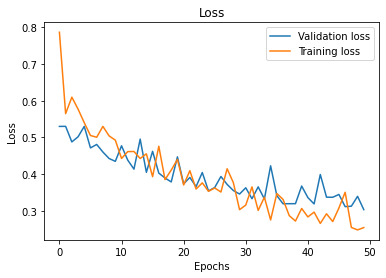

Training eval:
2/2 [==============================] - 0s 1ms/step - loss: 0.2313 - acc: 0.9000 - recall: 1.0000

Validation eval:
2/2 [==============================] - 0s 1ms/step - loss: 0.3037 - acc: 0.8800 - recall: 1.0000


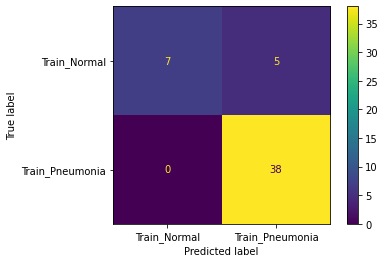

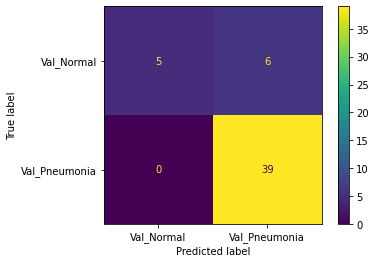

In [22]:
# Visualize the results
visualize_training_results(history, fsm, X_train, train_labels, X_val, val_labels)

**Analysis:**
The accuracy and loss are unstable and the model is overfit, likely because:
 - we are only training it on 50 images
 - loss of data from resizing the images down to 100x100 from original sizes
 - class imbalance (in favor of Pneumonia lungs)

### Iteration

To improve on our first simple model, we iterated over several more models. The following model represents several collective improvements over these iterations, such as:
 - Using the full dataset
 - Resize to 256x256 in order to balance information retention and computational need
 - Adding more Dense layers to improve the power of the network
 - Using L2 regularization to avoid overfitting
 - Using Adam optimizer function and specify learning rate to control stability during training
 - Adding class weights to account for imbalanced classes distribution
 
(To see the changes made for each individual iteration, see the code in our respective working notebooks.)

In [24]:
# Import and preprocess data
i5_X_train, i5_X_val, i5_train_labels, i5_val_labels = preprocess_dense_data(train_dir, batch_size=4000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [26]:
# Calculate class weights
i5_class_weights = get_class_weights(i5_train_labels)

In [27]:
# Instatiate model
i5_model = models.Sequential()

# Add model layers - More layers and with l2 regularization
i5_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i5_model.add(Dense(20, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(18, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(16, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(12, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(8, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(4, activation='relu', kernel_regularizer=l2(l2=0.01)))
i5_model.add(Dense(1, activation='sigmoid', ))


In [28]:
# Compile
adam = Adam(lr=0.001)
i5_model.compile(optimizer=adam,
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

# Train the model
i5_history = i5_model.fit(i5_X_train, i5_train_labels, 
                          epochs=100,
                          batch_size=32,
                          class_weight=i5_class_weights,
                          validation_data=(i5_X_val, i5_val_labels))

Epoch 1/100
125/125 [==============================] - 2s 20ms/step - loss: 1.4661 - acc: 0.2948 - recall: 0.0483 - val_loss: 1.1798 - val_acc: 0.5062 - val_recall: 0.3789
Epoch 2/100
125/125 [==============================] - 2s 18ms/step - loss: 0.9094 - acc: 0.7903 - recall: 0.7671 - val_loss: 0.8820 - val_acc: 0.9081 - val_recall: 0.9149
Epoch 3/100
125/125 [==============================] - 2s 18ms/step - loss: 0.6886 - acc: 0.9130 - recall: 0.9089 - val_loss: 0.7473 - val_acc: 0.8967 - val_recall: 0.8802
Epoch 4/100
125/125 [==============================] - 2s 17ms/step - loss: 0.4945 - acc: 0.9308 - recall: 0.9288 - val_loss: 0.4204 - val_acc: 0.9301 - val_recall: 0.9369
Epoch 5/100
125/125 [==============================] - 2s 17ms/step - loss: 0.4026 - acc: 0.9348 - recall: 0.9355 - val_loss: 0.4433 - val_acc: 0.9100 - val_recall: 0.9884
Epoch 6/100
125/125 [==============================] - 2s 15ms/step - loss: 0.4473 - acc: 0.9090 - recall: 0.9099 - val_loss: 0.3839 - val_a

125/125 [==============================] - 2s 16ms/step - loss: 0.0594 - acc: 0.9923 - recall: 0.9909 - val_loss: 0.2117 - val_acc: 0.9464 - val_recall: 0.9588
Epoch 96/100
125/125 [==============================] - 2s 16ms/step - loss: 0.0595 - acc: 0.9918 - recall: 0.9899 - val_loss: 0.2376 - val_acc: 0.9464 - val_recall: 0.9433
Epoch 97/100
125/125 [==============================] - 2s 16ms/step - loss: 0.0556 - acc: 0.9940 - recall: 0.9933 - val_loss: 0.3465 - val_acc: 0.9158 - val_recall: 0.8918
Epoch 98/100
125/125 [==============================] - 2s 16ms/step - loss: 0.0881 - acc: 0.9797 - recall: 0.9777 - val_loss: 0.1951 - val_acc: 0.9445 - val_recall: 0.9601
Epoch 99/100
125/125 [==============================] - 2s 16ms/step - loss: 0.0768 - acc: 0.9840 - recall: 0.9835 - val_loss: 0.1978 - val_acc: 0.9464 - val_recall: 0.9601
Epoch 100/100
125/125 [==============================] - 2s 15ms/step - loss: 0.0536 - acc: 0.9950 - recall: 0.9936 - val_loss: 0.2159 - val_acc: 0.

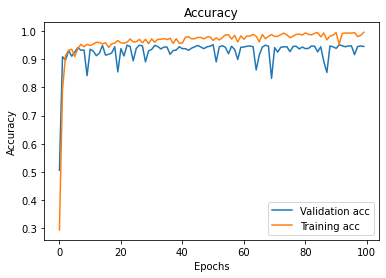

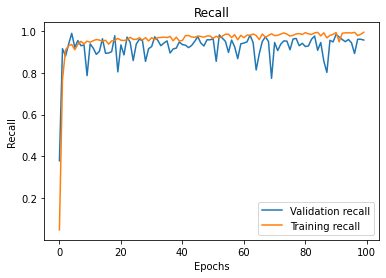

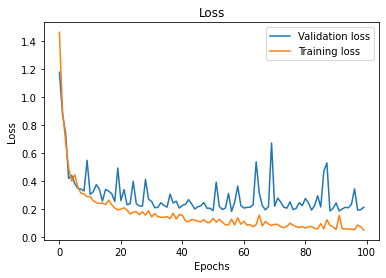

Training eval:
125/125 [==============================] - 1s 5ms/step - loss: 0.0501 - acc: 0.9967 - recall: 0.9960

Validation eval:
33/33 [==============================] - 0s 5ms/step - loss: 0.2159 - acc: 0.9445 - recall: 0.9562


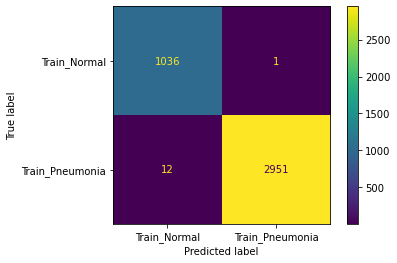

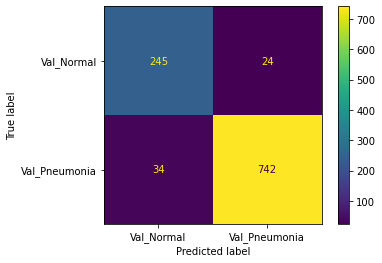

In [29]:
visualize_training_results(i5_history, i5_model, i5_X_train, i5_train_labels, i5_X_val, i5_val_labels)

Our changes to the model both reduced overfitting and increased performance on recall and general accuracy, bringing accuracy up to 94.5% and recall to 95.6%.

Despite iterative improvements, our models using only fully connected Dense layers hit a ceiling around 95% for accuracy and recall on the validation set. We decided to add convolutional layers in order to continue improving the model. The hope is that the model will identify more granular patterns in the data by using convolutional layers with filters and pooling layers.

### First CNN model

We add a new `preprocess` function that returns the `train_generator` and `val_generator` rather than an array of images as we no longer have to reshape/flatten the images before feeding them into the model. This will also allows us to more easily use the full dataset in training. For our first CNN model we have used an architecture from the Flatiron curriculum as a starting point.

**Note:** While the Dense models fit in a matter of minutes or even seconds, the CNN models often take a couple hours to fit. As a result, we have saved some models as `'*.h5'` files and reloaded some of them into this notebook rather than refitting them. The original code for each model can be found in our respective working notebooks.

In [31]:
# Preprocess the data
train_gen_1, val_gen_1 = preprocess_cnn_data(train_dir, batch_size=50)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [33]:
# Get the class weights
class_weights_1 = get_class_weights(train_gen_1.classes)
class_weights_1

{0: 1.938425925925926, 1: 0.6738010943031864}

In [34]:
# Instatiate model
cnn_model_1 = models.Sequential()

# Add model layers - Using architecture from Canvas 'CNN from Scratch - Lab' to start
cnn_model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D((2, 2)))
# Flatten
cnn_model_1.add(Flatten())
# Final Dense layers
cnn_model_1.add(Dense(512, activation='relu'))
cnn_model_1.add(Dense(1, activation='sigmoid'))

# Compile
cnn_model_1.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=['acc', 'Recall'])

In [35]:
# Train the model
history_1 = cnn_model_1.fit(train_gen_1,
                            steps_per_epoch=40, 
                            epochs=15, 
                            validation_data=val_gen_1, 
                            class_weight=class_weights_1,
                            validation_steps=20)

Epoch 1/15
40/40 [==============================] - 150s 4s/step - loss: 0.7217 - acc: 0.6940 - recall: 0.6810 - val_loss: 0.3823 - val_acc: 0.8480 - val_recall: 0.8482
Epoch 2/15
40/40 [==============================] - 150s 4s/step - loss: 0.3577 - acc: 0.8596 - recall: 0.8494 - val_loss: 0.2793 - val_acc: 0.8760 - val_recall: 0.8851
Epoch 3/15
40/40 [==============================] - 150s 4s/step - loss: 0.2392 - acc: 0.9074 - recall: 0.9040 - val_loss: 0.2059 - val_acc: 0.9290 - val_recall: 0.9248
Epoch 4/15
40/40 [==============================] - 151s 4s/step - loss: 0.1534 - acc: 0.9370 - recall: 0.9315 - val_loss: 0.2184 - val_acc: 0.9200 - val_recall: 0.9685
Epoch 5/15
40/40 [==============================] - 156s 4s/step - loss: 0.1434 - acc: 0.9450 - recall: 0.9439 - val_loss: 0.2698 - val_acc: 0.9100 - val_recall: 0.9822
Epoch 6/15
40/40 [==============================] - 157s 4s/step - loss: 0.1506 - acc: 0.9480 - recall: 0.9468 - val_loss: 0.2114 - val_acc: 0.9390 - val_r

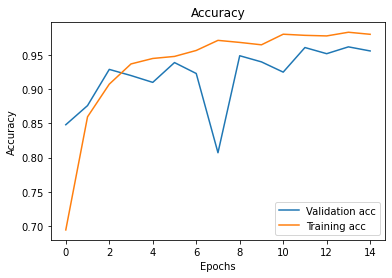

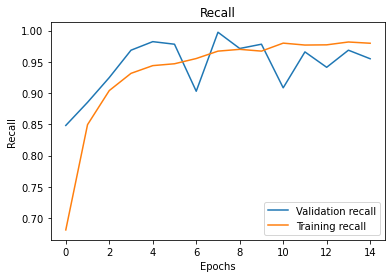

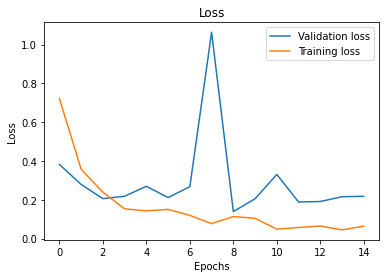

Training eval:
84/84 [==============================] - 76s 909ms/step - loss: 0.0340 - acc: 0.9852 - recall: 0.9813

Validation eval:
21/21 [==============================] - 18s 847ms/step - loss: 0.2087 - acc: 0.9579 - recall: 0.9575


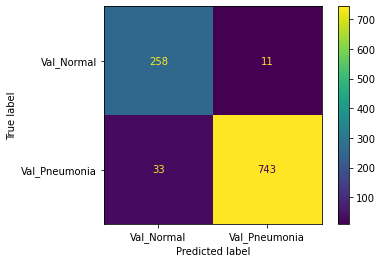

In [39]:
visualize_results_cnn(history_1, cnn_model_1, train_gen_1, val_gen_1)

This first CNN model improved on both accuracy and recall on the validation set. However, it is still leaving more false-negatives than we would want and as we continue to iterate we will focus on bringing up recall, even at the cost of accuracy. False positives have potentially fewer serious consequences (continued observation, more testing) than false negatives (untreated disease and fatality), especially with pediatric patients.

### Further CNN iterations

We continued to iterate with CNN models, adjusting various layers and parameters, including:
 - Introducing `BatchNormalization` layers, which reduce the range of input values to speed training and improve performance
 - Adding L2 regularization to avoid overfitting
 - Adjusting number of layers to change the complexity of the model
 - Reducing number of epochs to potentially avoid overfitting
 - Increasing kernel (filter) size from (3, 3) to (5, 5)

Collectively, we iterated on over a dozen models, adjusting these parameters among others. The following is one example of this iterative process; the others can be seen in our working notebooks.

In [40]:
cnn_model_4 = models.load_model('models/cnn_model_4.h5')

In [42]:
# Load and preprocess the data
train_gen_4, val_gen_4 = preprocess_cnn_data(train_dir, batch_size=50)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [41]:
# Display model architecture
cnn_model_4.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 123, 123, 64)      51264     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 57, 57, 128)       204800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 57, 57, 128)       512       
_________________________________________________________________
activation_4 (Activation)    (None, 57, 57, 128)     

In [46]:
# Display metrics and evaluation
cnn_model_4.evaluate(train_gen_4)

84/84 [==============================] - 103s 1s/step - loss: 0.0020 - acc: 0.9995 - recall: 0.9994


[0.002024430315941572, 0.99952232837677, 0.9993562698364258]

In [47]:
cnn_model_4.evaluate(val_gen_4)

21/21 [==============================] - 22s 1s/step - loss: 0.1099 - acc: 0.9742 - recall: 0.9716


[0.10985701531171799, 0.9741626977920532, 0.9716494679450989]

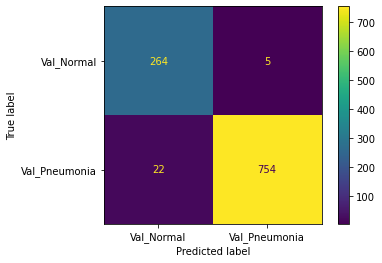

In [51]:
# Confusion matrix for validation set
y_val_preds = (cnn_model_4.predict(val_gen_4) > 0.5).astype('int32')
ConfusionMatrixDisplay(confusion_matrix(val_gen_4.labels, y_val_preds),
                       display_labels=['Val_Normal', 'Val_Pneumonia']).plot();

This model has a validation accuracy of 97.42% and recall of 97.16%. The confusion matrix shows that there are significantly more false negatives than false positives. For reasons discussed above, we want to reduce false negatives as much as possible while maintaining decent accuracy, even at the expense of false postiives.

### Best CNN model

After iterating through many different models, we decided on the following model as our final best model based on validation scores.

In [4]:
final_model = models.load_model('models/final_model.h5')

In [19]:
# Load and preprocess the data
train_gen_5, val_gen_5, test_gen_5 = preprocess_cnn_data(train_dir, test_dir, batch_size=50)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 123, 123, 64)      51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 57, 57, 128)       204800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 57, 57, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 57, 57, 128)      

## Final Evaluation

On unseen testing data, our best best model had 98.46% recall and 80.93% accuracy. Out of 624 images in the test set, the model predicted 6 false negatives and 112 false positive, with 506 correct predictions. We suspect that the low accuracy score is due to imbalance in the dataset. Chest X-rays of patients with pneumonia made up 62.5% of the test set, while chest X-rays of healthy patients made up 37.5% of the test set. 

In [12]:
final_model.evaluate(train_gen_5)

84/84 [==============================] - 533s 6s/step - loss: 0.1732 - accuracy: 0.9809 - recall: 0.9762


[0.17318978905677795, 0.9808932542800903, 0.9761828184127808]

In [13]:
final_model.evaluate(val_gen_5)

21/21 [==============================] - 128s 6s/step - loss: 0.2110 - accuracy: 0.9617 - recall: 0.9562


[0.21095222234725952, 0.9617224931716919, 0.9561855792999268]

In [14]:
final_model.evaluate(test_gen_5)

13/13 [==============================] - 47s 4s/step - loss: 0.7125 - accuracy: 0.8093 - recall: 0.9846


[0.7124913334846497, 0.8092948794364929, 0.9846153855323792]

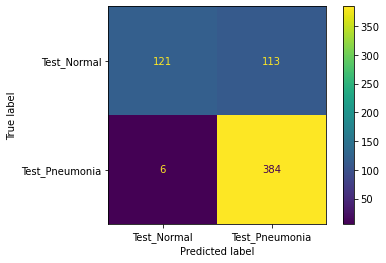

In [20]:
y_test_preds = (final_model.predict(test_gen_5) > 0.5).astype('int32')
ConfusionMatrixDisplay(confusion_matrix(test_gen_5.labels, y_test_preds),
                       display_labels=['Test_Normal', 'Test_Pneumonia']).plot();

Our model performed very well by our primary metric (recall), but has a lower accuracy on the testing set than on the validation set. The number of false positives is higher than we expected or would want, so futher iterations of the model would focus on lowering that number. It may even be possible to train another model specifically on misclassified images.

## Exploring the model

### Misclassified Images (false positives and negatives)

Let's take a look at the images that have been misclassified to see if any patterns can be identified that may represent obvious errors in the model.

In [69]:
# Get indicies of misclassfied images
# From https://stackoverflow.com/questions/39300880/how-to-find-wrong-prediction-cases-in-test-set-cnns-using-keras
incorrects = np.nonzero((final_model.predict(test_gen_5)>0.5).reshape((-1,)) != test_gen_5.labels)[0]

# Get a batch of images and labels from the generator
images, labels = next(test_gen_5)

# Lists of indicies
false_positives = [i for i in incorrects if test_gen_5.labels[i]==0]
false_negatives = [i for i in incorrects if test_gen_5.labels[i]==1]


Check the results:

In [84]:
len(false_positives)

113

In [83]:
print(len(false_negatives))

6


The length of each list matches the false negatives and false positives in our confusion matrix.

Let's check the filenames as well.

In [90]:
filenames = test_gen_5.filenames

fp_names = [filenames[i] for i in false_positives]

fp_names[40]

'NORMAL/NORMAL2-IM-0145-0001.jpeg'

As expected, false positives are normal lungs.

In [89]:
fn_names = [filenames[i] for i in false_negatives]

for name in fn_names:
    print(name)

PNEUMONIA/person119_bacteria_567.jpeg
PNEUMONIA/person130_bacteria_623.jpeg
PNEUMONIA/person153_bacteria_726.jpeg
PNEUMONIA/person154_bacteria_728.jpeg
PNEUMONIA/person1608_virus_2786.jpeg
PNEUMONIA/person83_bacteria_407.jpeg


Interestingly, although viral pneumonia is more difficult to spot and diagnose, most of the false negatives are images showing bacterial pneumonia.

Let's take a look at some of the misclassified images.

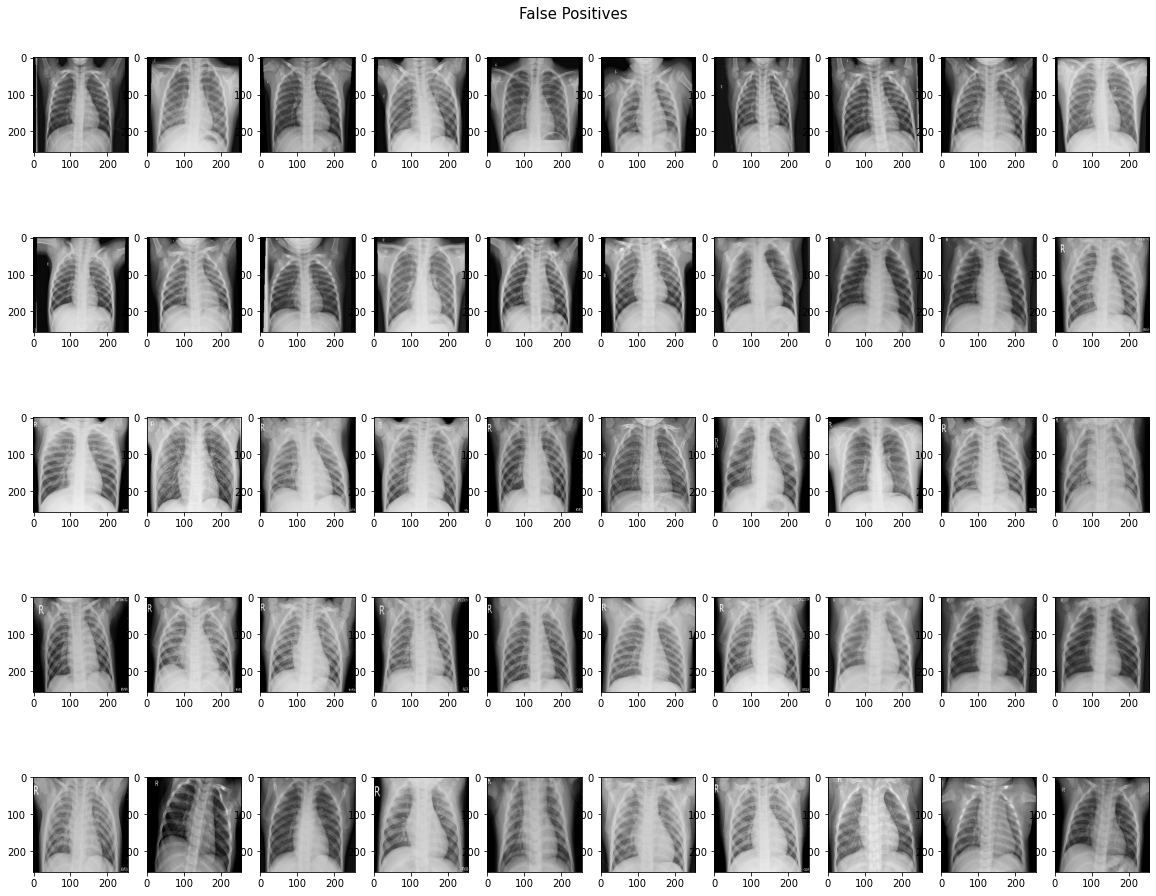

In [78]:
# 50 false positives
fig, axs = plt.subplots(5,10, figsize=(20, 16))
fig.suptitle('False Positives', fontsize=15, y=0.9)
for i, ax in enumerate(axs.ravel()):
    try:
        ax.imshow(images[i].reshape(256, -1), cmap='gray')
    except:
        break

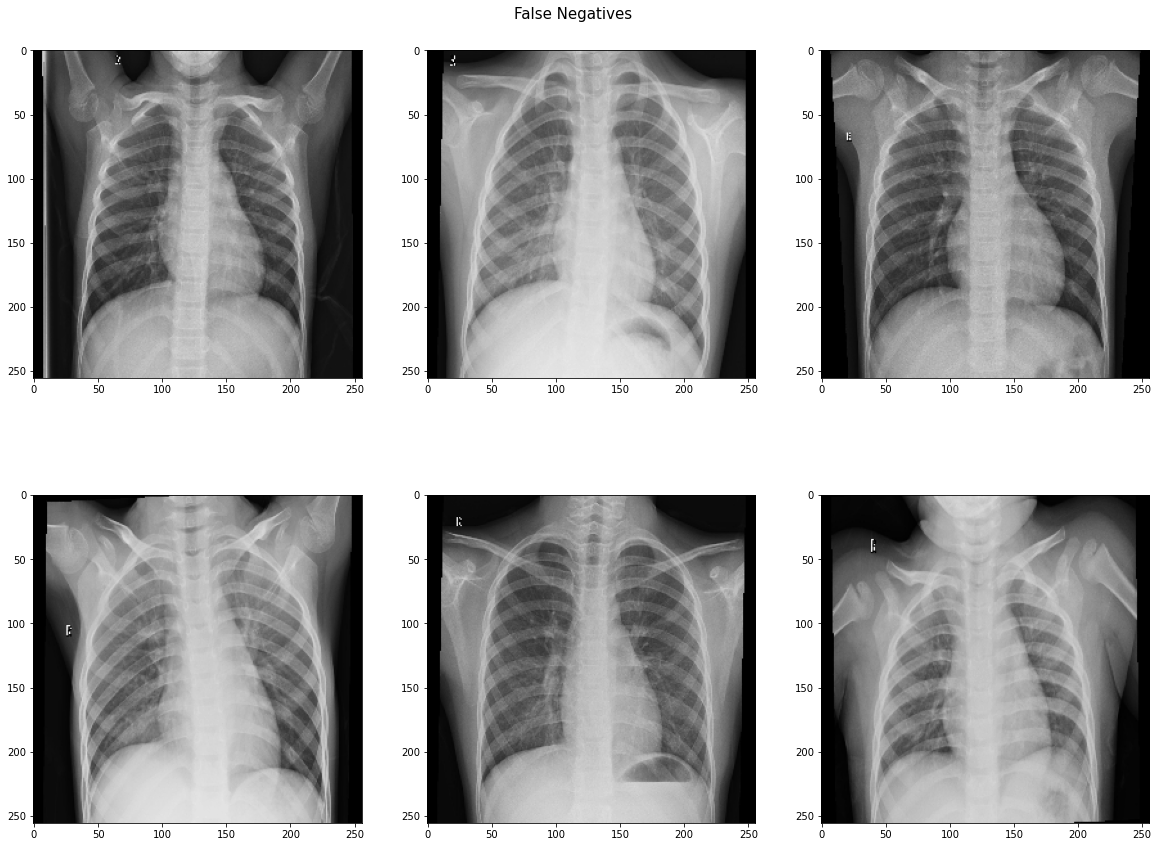

In [76]:
# False negatives
fig, axs = plt.subplots(2,3, figsize=(20,15))
fig.suptitle('False Negatives', fontsize=15, y=0.9)
for i, ax in enumerate(axs.ravel()):
    try:
        ax.imshow(images[i].reshape(256, -1), cmap='gray')
    except:
        break

We lack the domain knowledge expertise to identify or interpret patterns in the misclassified images. Ideally, we would partner with medical professionals to see what patterns may exist that are being caught and misclassified by the model.

### Visualizing Intermediate Layers

In order to explore the transformations made to misclassifed images as they pass through different filters and layers of the model to confirm the model is analyzing relevant features (i.e., the lungs in the CXR and not noise such as the 'R' on almost every image), we visualize the intermediate layers of the model. This allows us to peer into the "black box" of the model and look at the patterns in the images that each filter is attending to.

*The following code is sourced from a piece of Flatiron School's curriculum titled, 'Visualizing Intermediate Activations'*

(1, 256, 256, 1)


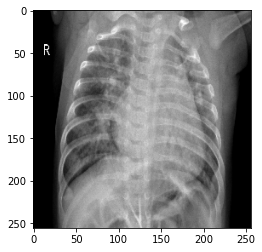

In [91]:
img_path = 'chest_xray/test/PNEUMONIA/person130_bacteria_623.jpeg'
img_path2 = 'chest_xray/test/NORMAL/NORMAL2-IM-0145-0001.jpeg'


img = image.load_img(img_path, color_mode='grayscale', target_size=(256, 256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

img2 = image.load_img(img_path2, color_mode='grayscale', target_size=(256, 256))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

img_tensor2 /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0], cmap='gray')
plt.show()

In [92]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in final_model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=final_model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

The following image shows the first activation layer--in other words, the first `Conv2D` convolutional layer in our final model--when the above image is fed into the model.

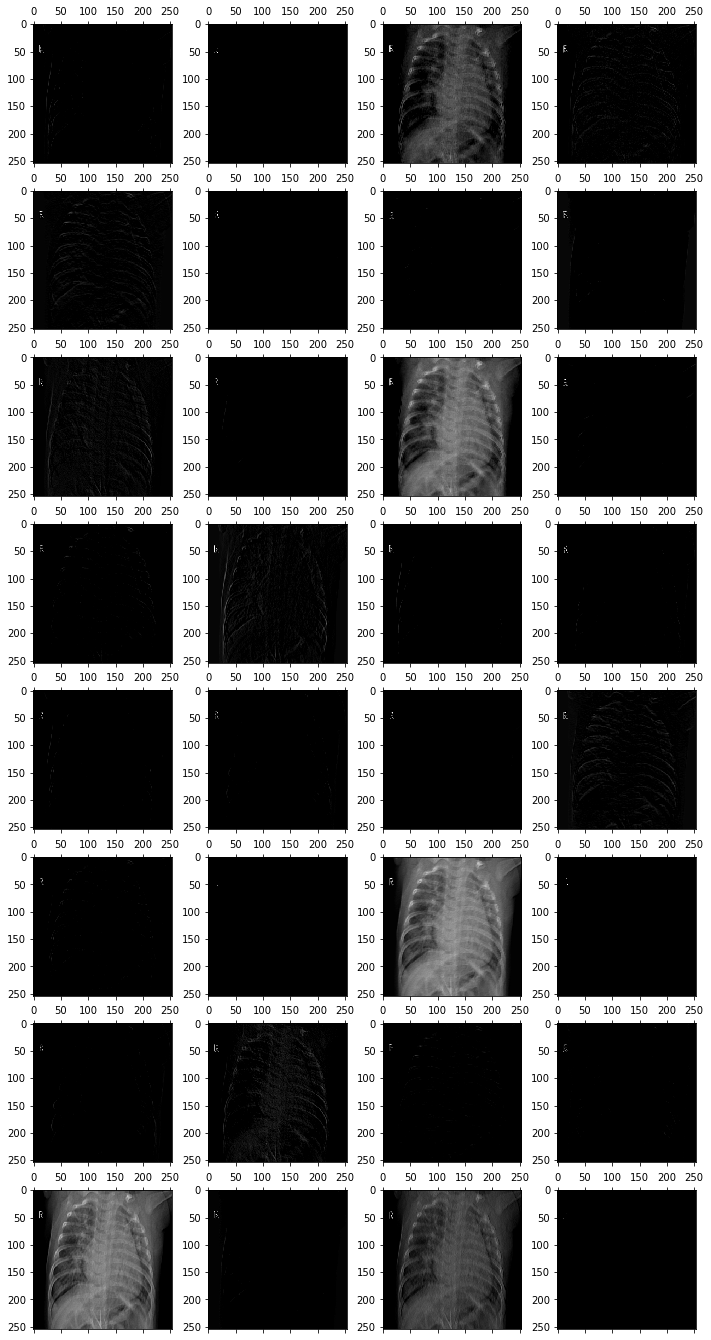

In [93]:
# Plot all filters from the first activation layer
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='gray')

Now, rather than examining all channels from one layer, let's look at one channel from *each* layer. Note the name above each image to identify which layer of the model it comes from.

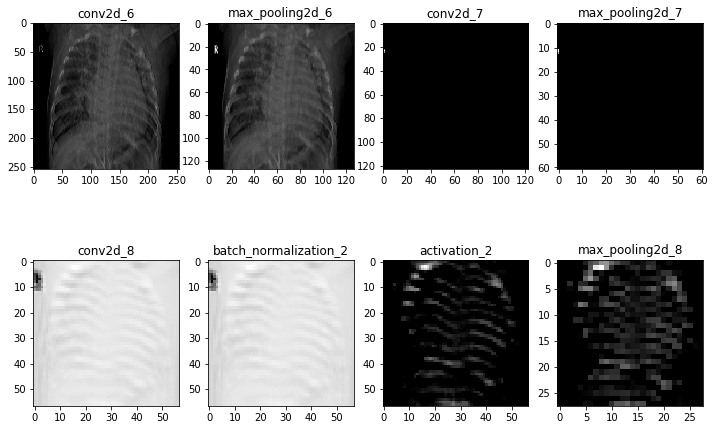

In [94]:
# Plot one filter from each activation layer
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in final_model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 30], cmap='gray')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

We'll repeat the process for another image to examine its effect on the filters and activation layers.

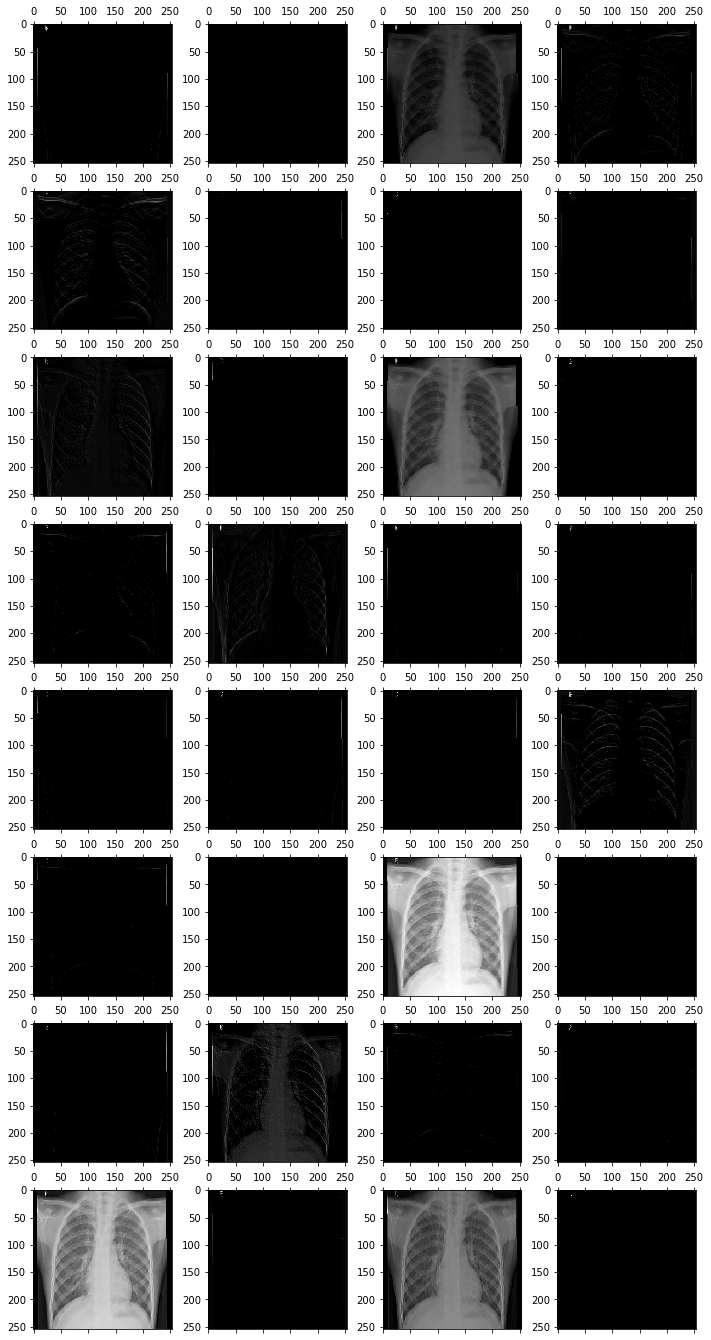

In [95]:
activations2 = activation_model.predict(img_tensor2)

fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations2[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='gray')

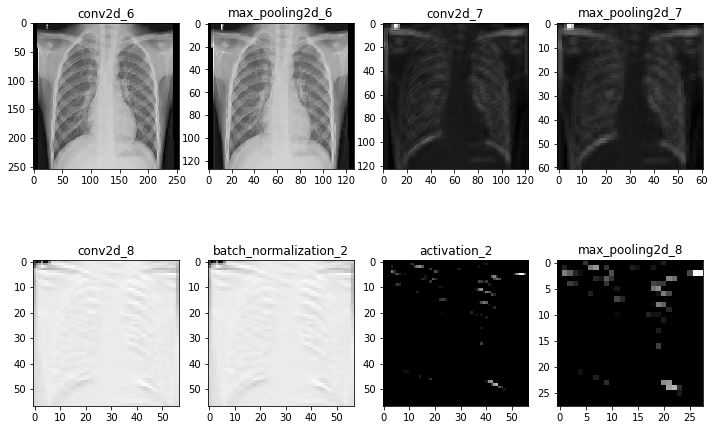

In [98]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in final_model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer2 = activations2[i]
    ax.matshow(cur_layer2[0, :, :, 28], cmap='gray')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

It does not appear from this albiet brief exploration that the model is obviously focusing on any particular irrelevant detail. However, further exploration could uncover systemic errors or other issues in the model. Ideally, we would partner with medical professionals who could help us better assess what features or patterns the model is likely identifying in the normal and target pneumonia class images.

## Conclusions

### Recommendations

We recommend that this model is used as part of a medical professional's diagnostic toolkit, in conjunction with a clinical assessment. We suggest that this model is used to reduce the rate of false negatives among those patients the model predicts have pneumonia. The model would likely save time as it can make diagnoses at scale very quickly.

We also recommend consulting with a medical professional, who has experience diagnosing a patient with pneumonia by looking at chest X-rays, about false positive and false negative images to determine patterns they look for, and ultimately what the model is missing.


### Possible Next Steps

 - Creating a neural network capable of multiclass classification to predict three targets in the dataset, healthy patients, patients with bacterial pneumonia, and patients with viral pneumonia. 

 - Cropping images of chest X-rays, or using data augmentation, to include only data within the rib cage, limiting the interference from extremities as much as possible while training the model.

 - Seeking to idenitfy patterns in misclassified images to improve overall accuracy, especially in conjunction with medical professionals. 

 - Finally, we would create another neural network to classify chest X-rays of pateints with covid-19 or pneumonia.
